# Hematopoiesis - RNA velocity

Infer RNA velocity on NeurIPS 2021 hematopoiesis data.

In [1]:
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

from cr2 import get_state_purity, plot_state_purity, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "pseudotime_kernel" / "hematopoiesis").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "hematopoiesis" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
N_JOBS = 8

In [7]:
CELLTYPES_TO_KEEP = [
    "HSC",
    "MK/E prog",
    "Proerythroblast",
    "Erythroblast",
    "Normoblast",
    "cDC2",
    "pDC",
    "G/M prog",
    "CD14+ Mono",
]

## Data loading

In [8]:
adata = sc.read(DATA_DIR / "hematopoiesis" / "processed" / "gex_velocity.h5ad")
adata

AnnData object with n_obs × n_vars = 67568 × 25629
    obs: 'batch', 'site', 'donor', 'l1_cell_type', 'l2_cell_type'
    var: 'hvg_multiVI'
    uns: 'neighbors'
    obsm: 'MultiVI_latent', 'X_umap'
    layers: 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

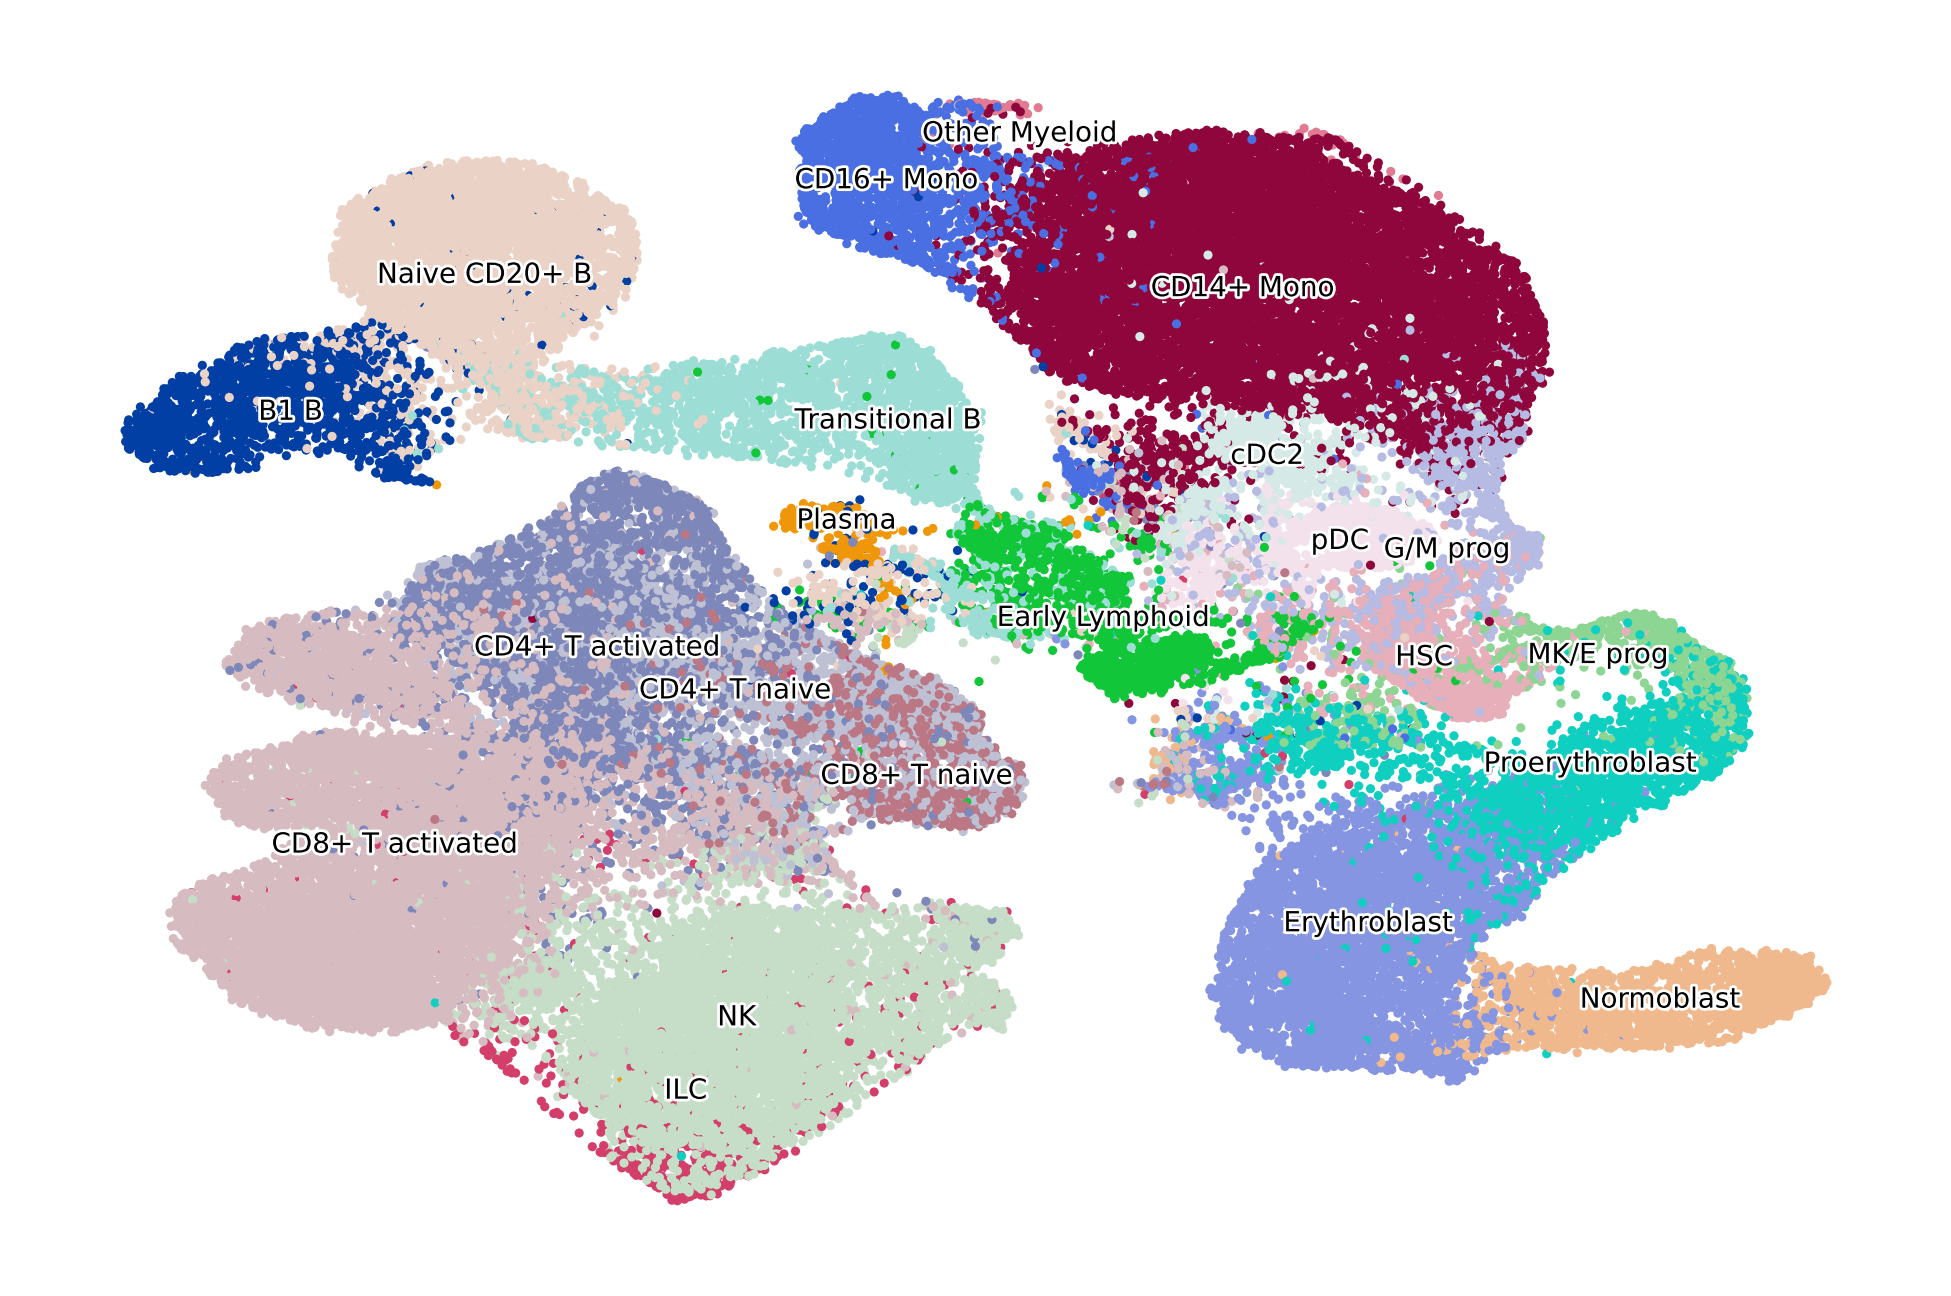

In [9]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="X_umap", c="l2_cell_type", dpi=200, title="", legend_fontsize=5, legend_fontweight=1)

## Data preprocessing

In [10]:
adata = adata[adata.obs["l2_cell_type"].isin(CELLTYPES_TO_KEEP), :].copy()
adata

AnnData object with n_obs × n_vars = 24440 × 25629
    obs: 'batch', 'site', 'donor', 'l1_cell_type', 'l2_cell_type'
    var: 'hvg_multiVI'
    uns: 'neighbors', 'l2_cell_type_colors'
    obsm: 'MultiVI_latent', 'X_umap'
    layers: 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [11]:
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)

Filtered out 16169 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.


In [12]:
sc.pp.neighbors(adata, use_rep="MultiVI_latent")
sc.tl.umap(adata)

computing neighbors
    finished (0:02:27)
computing UMAP
    finished (0:00:10)


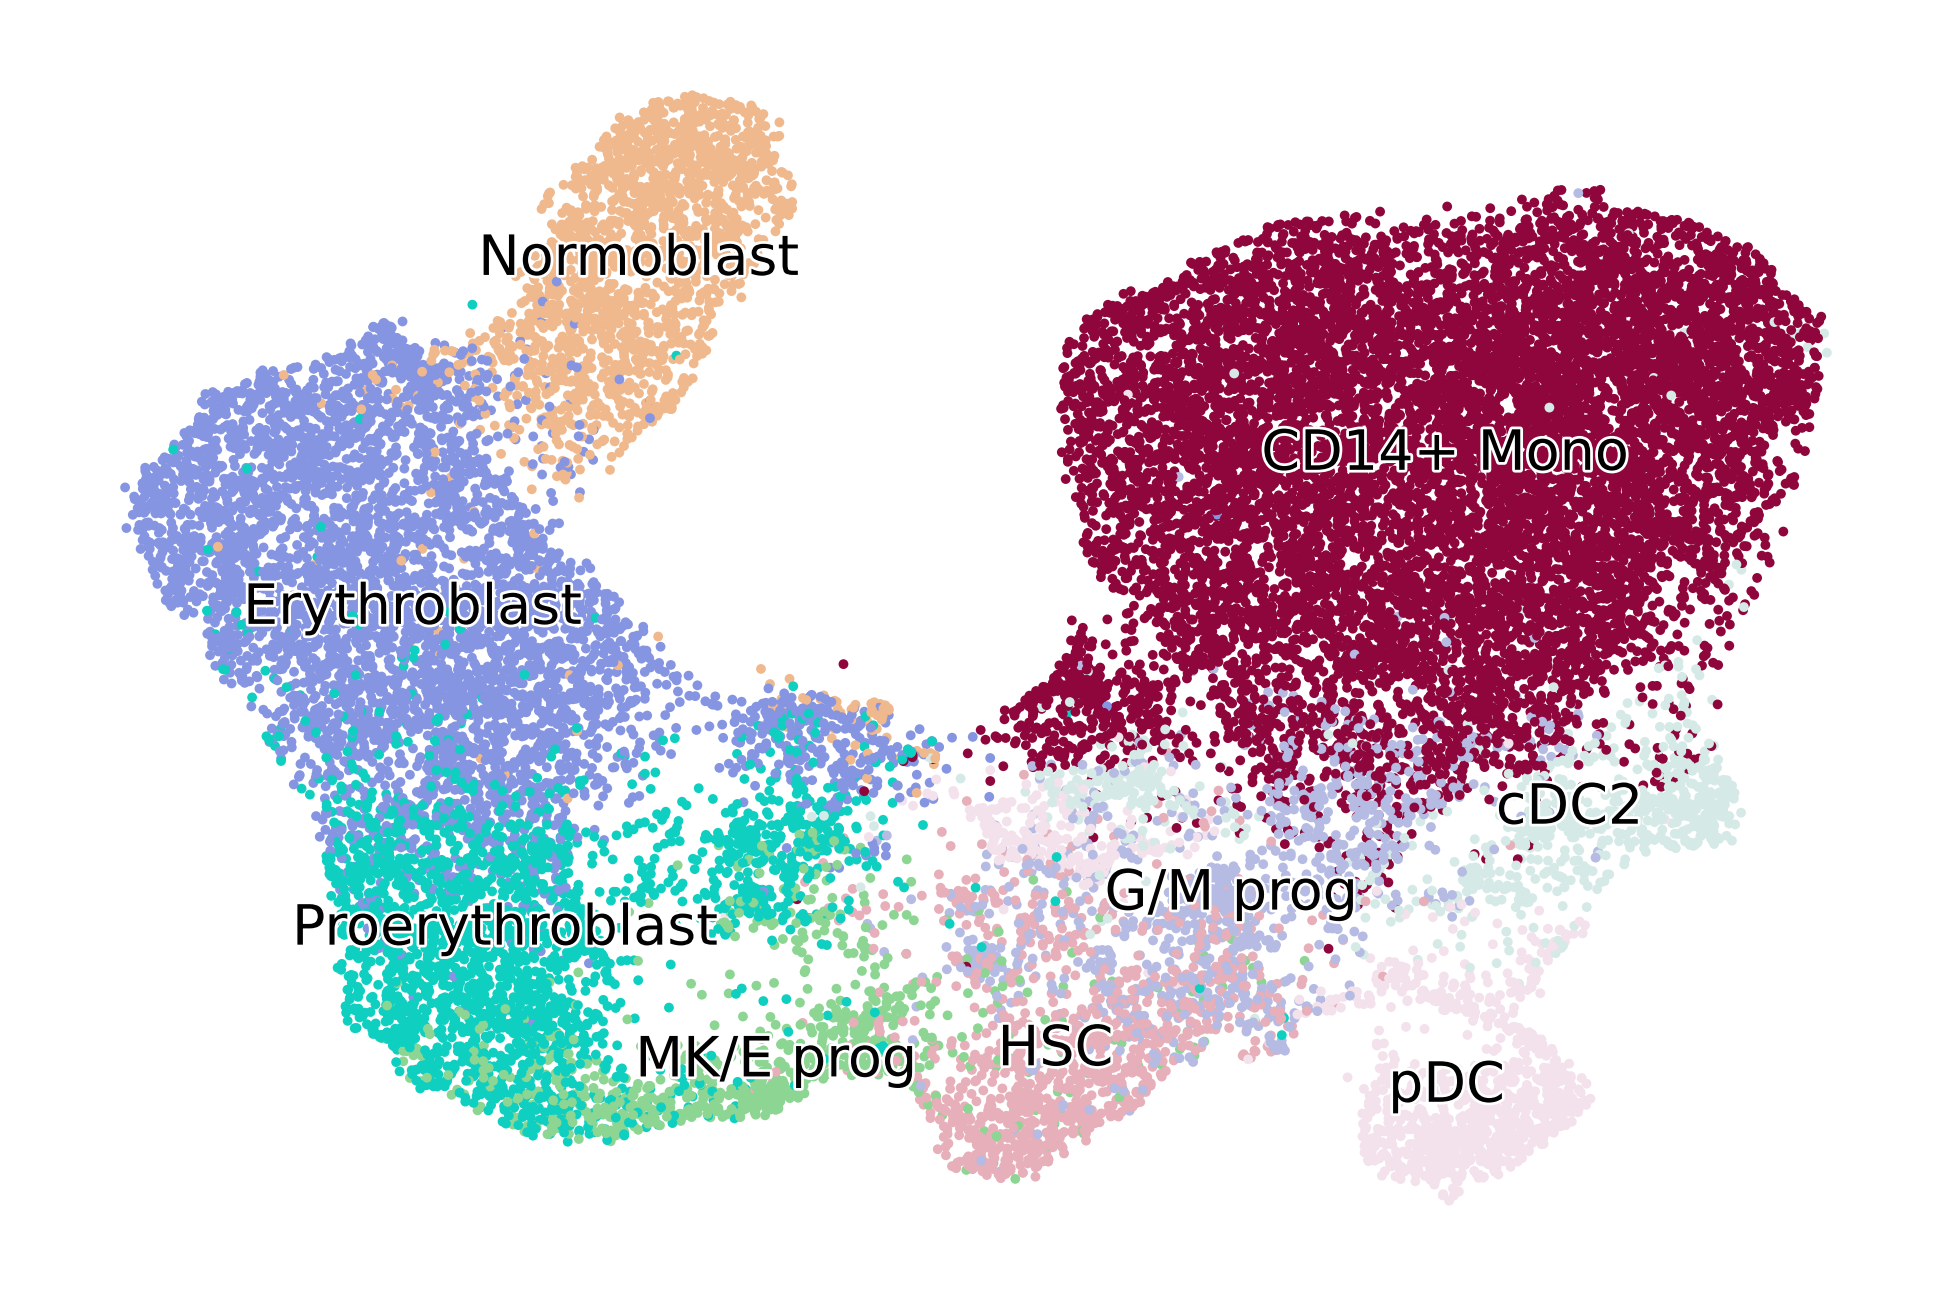

In [13]:
if running_in_notebook():
    scv.pl.scatter(
        adata,
        basis="X_umap",
        c="l2_cell_type",
        dpi=200,
        title="",
        legend_fontsize=10,
        legend_fontweight=5,
    )

In [14]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


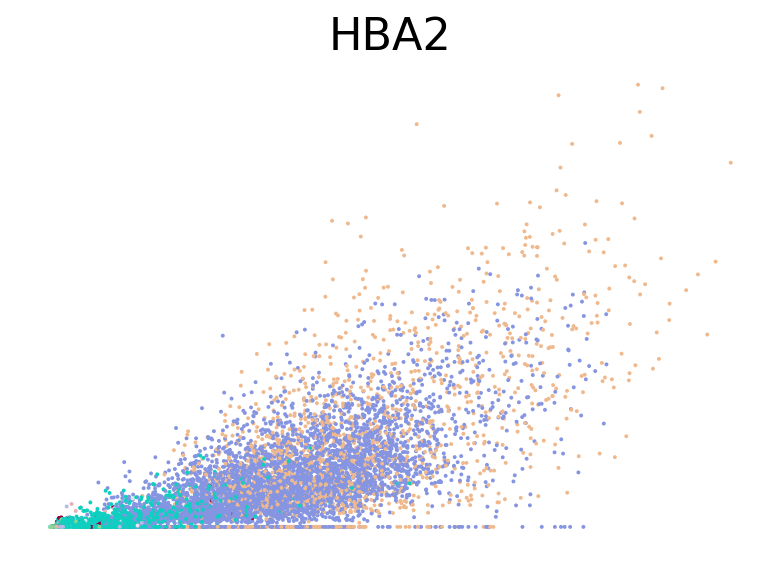

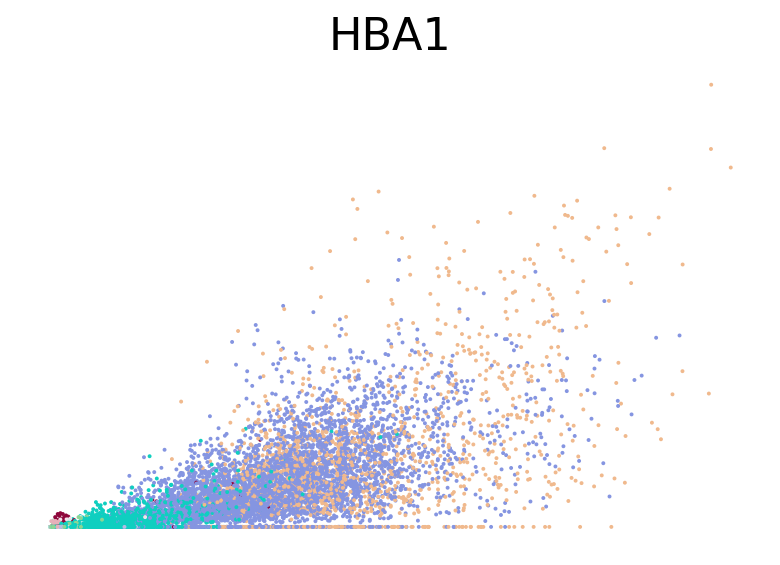

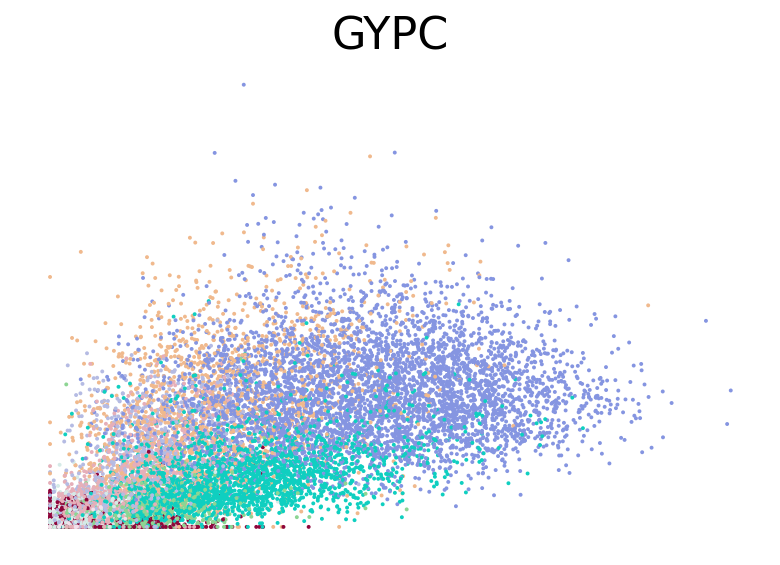

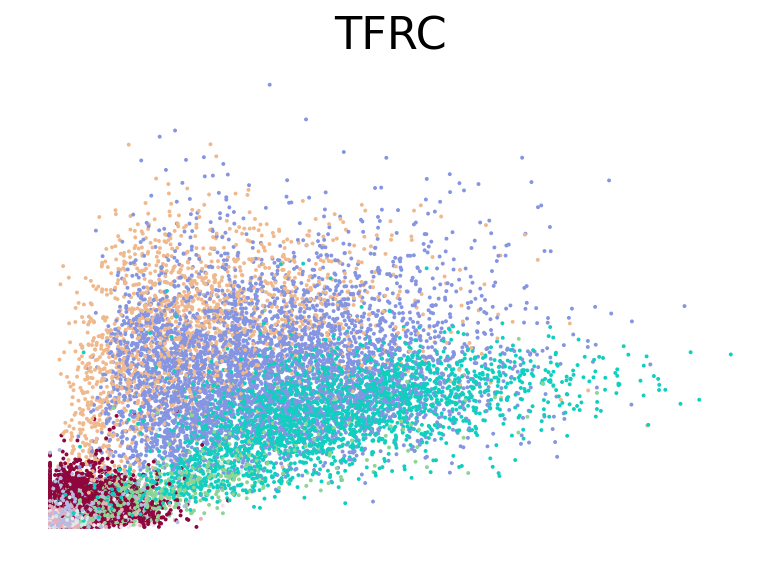

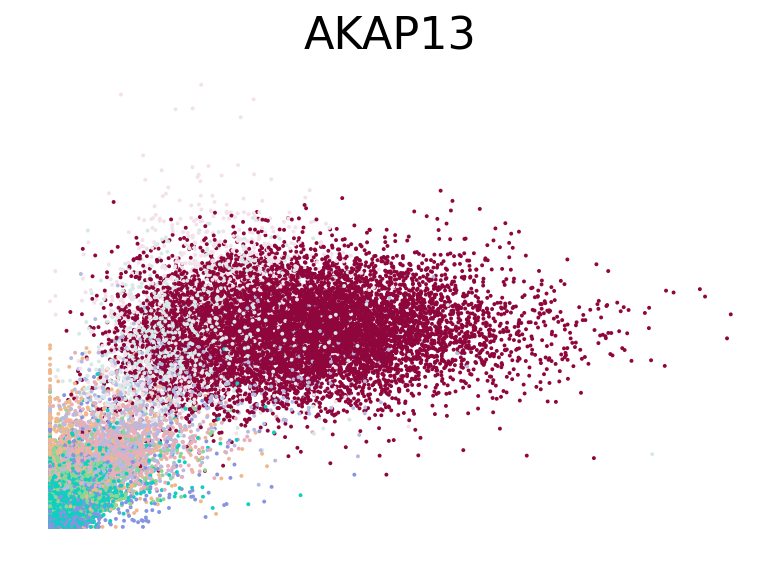

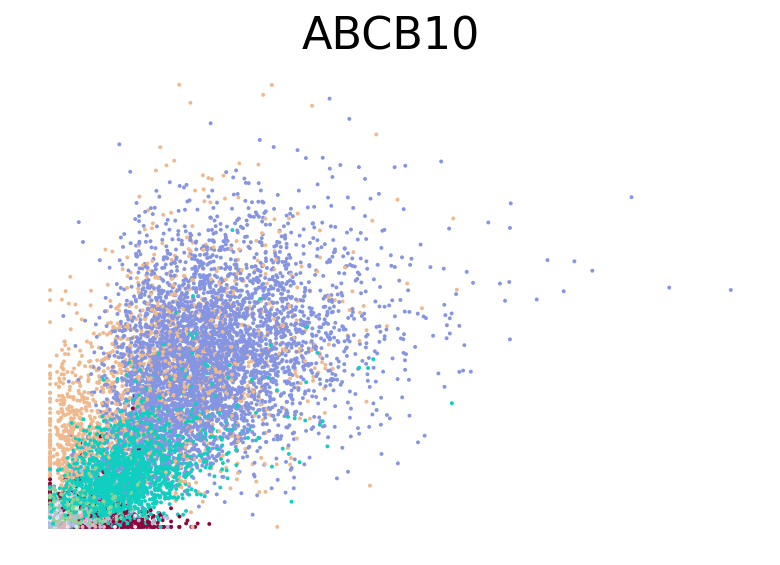

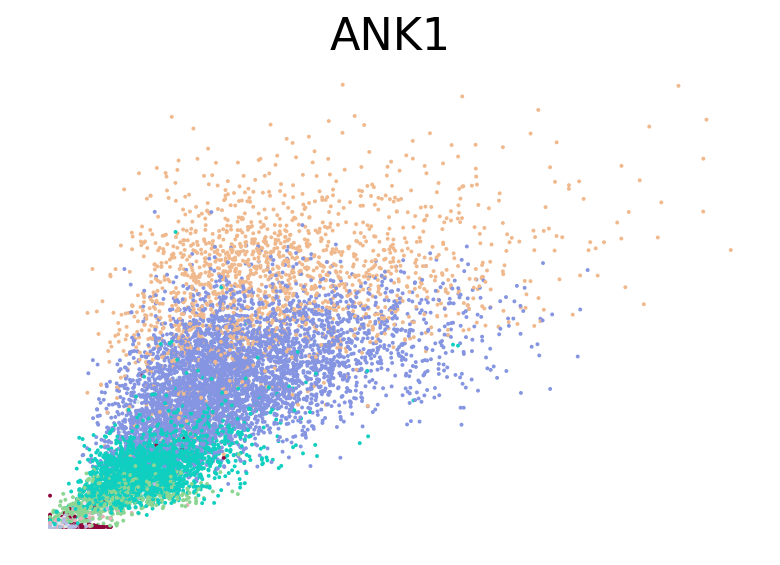

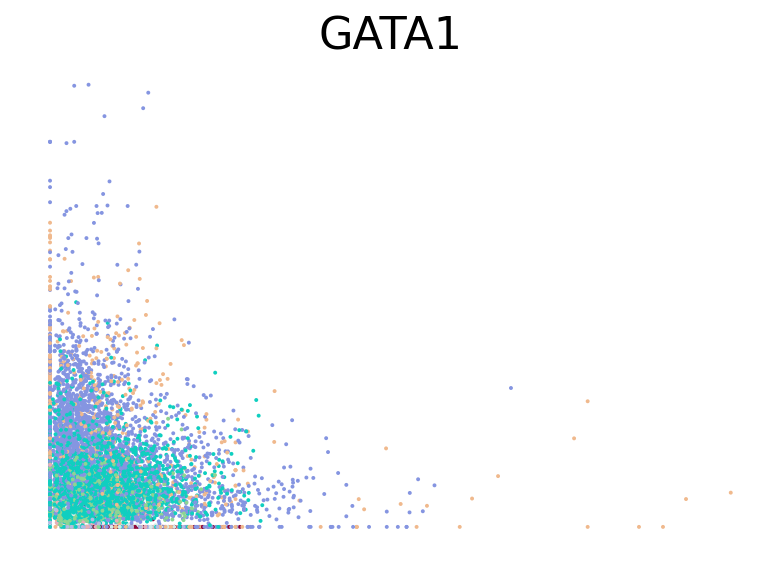

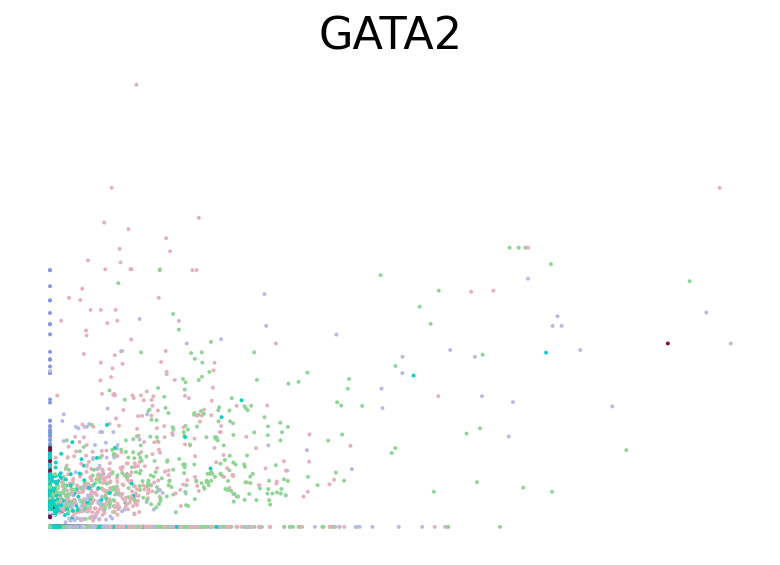

In [15]:
for gene in ["HBA2", "HBA1", "GYPC", "TFRC", "AKAP13", "ABCB10", "ANK1", "GATA1", "GATA2"]:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis=gene, color="l2_cell_type", frameon=False, ax=ax)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"phase_portrait_{gene}.{FIGURE_FORMAT}",
            format=FIGURE_FORMAT,
            transparent=True,
            bbox_inches="tight",
        )

## RNA velocity inference

In [16]:
scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)

recovering dynamics (using 8/14 cores)


  0%|          | 0/1504 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:03:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [17]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## CellRank analysis

### Kernel

In [18]:
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/24440 [00:00<?, ?cell/s]

Using `softmax_scale=10.3350`


  0%|          | 0/24440 [00:00<?, ?cell/s]

    Finish (0:00:20)
Computing transition matrix based on `adata.obsp['connectivities']`
DEBUG: Density normalizing the transition matrix
    Finish (0:00:00)


Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:07)


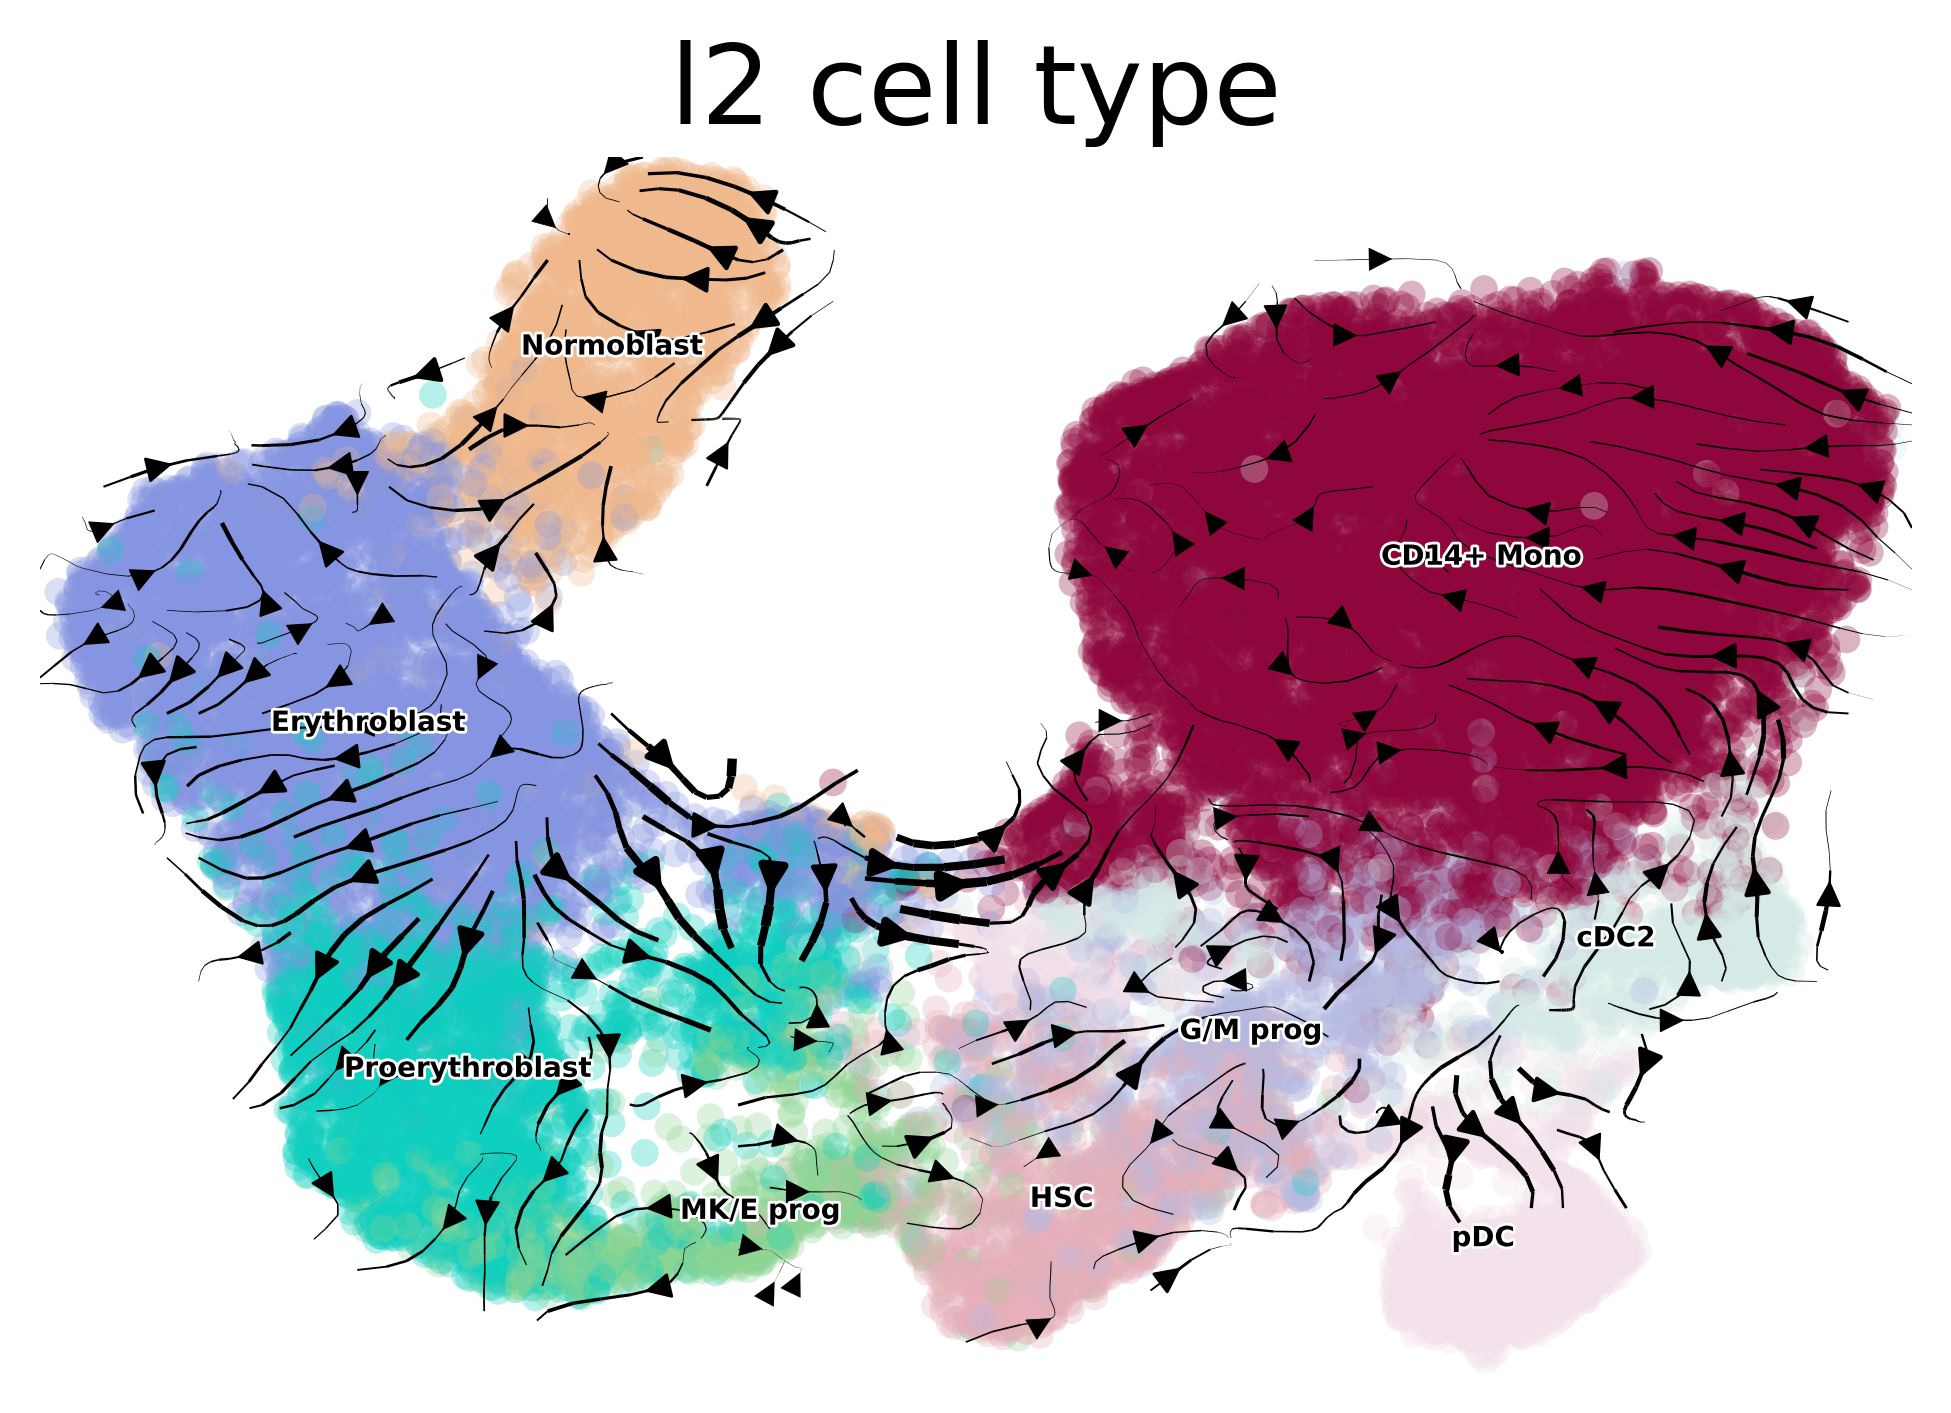

In [19]:
combined_kernel.plot_projection(color="l2_cell_type", recompute=True, basis="X_umap", dpi=200, legend_fontsize=5)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    combined_kernel.plot_projection(
        color="l2_cell_type",
        recompute=True,
        basis="X_umap",
        title="",
        legend_loc="none",
        alpha=0.25,
        linewidth=2,
        ax=ax,
    )

    fig.savefig(
        FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"rna_velocity_stream.{FIGURE_FORMAT}",
        format=FIGURE_FORMAT,
        transparent=True,
        bbox_inches="tight",
        dpi=400,
    )

### Estimator

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[10, 20]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


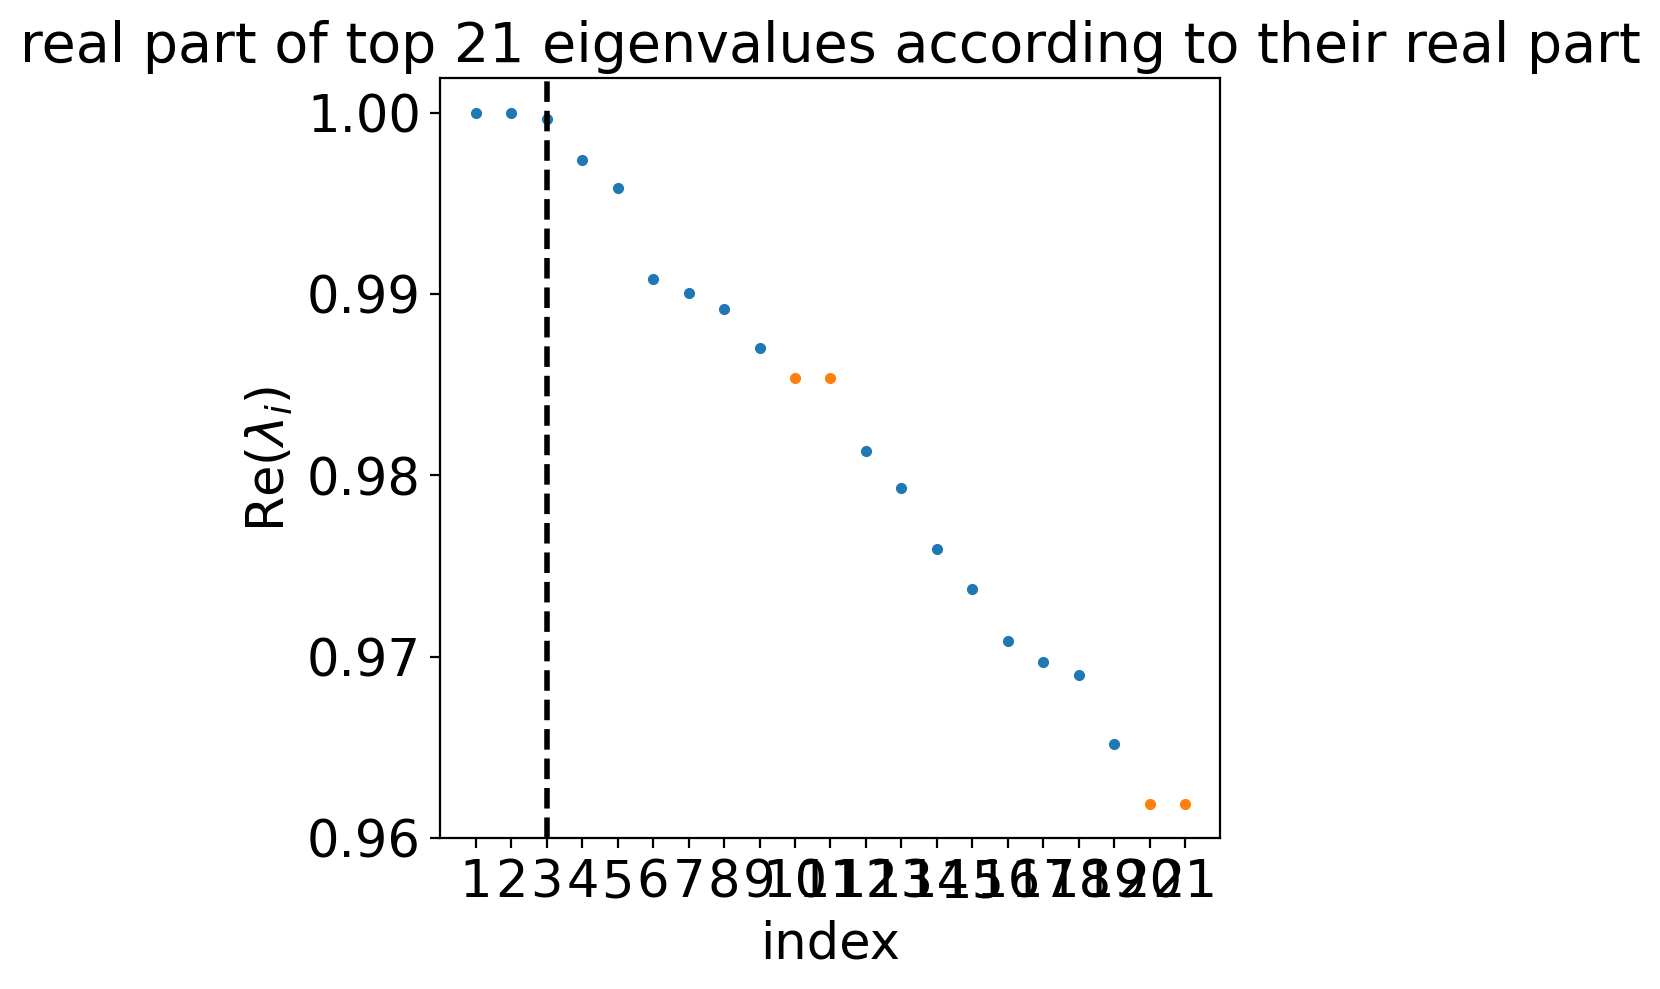

In [20]:
estimator = cr.estimators.GPCCA(combined_kernel)
estimator.compute_schur(n_components=20)
estimator.plot_spectrum(real_only=True)

Computing `3` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


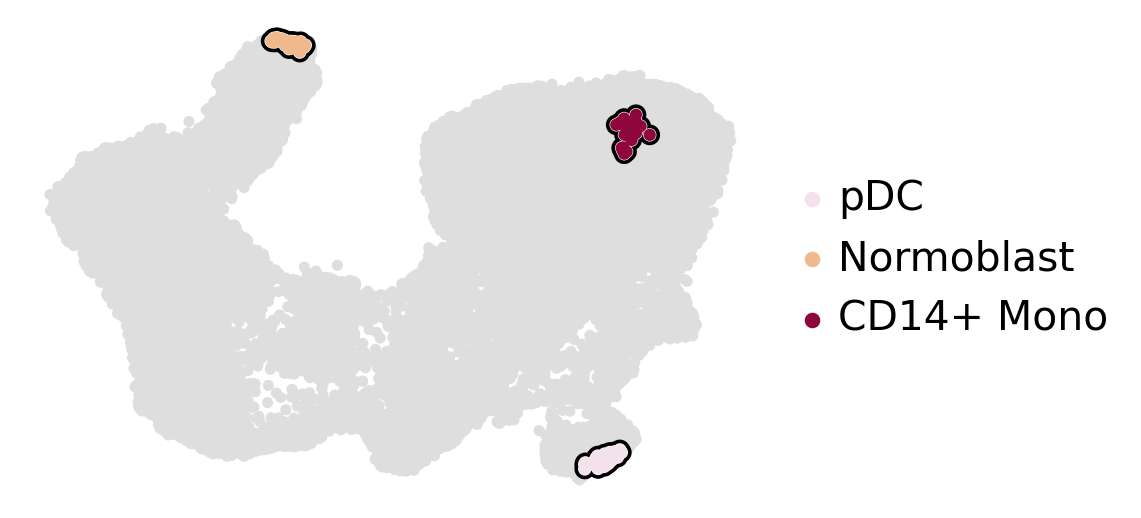

In [21]:
estimator.compute_macrostates(n_states=3, cluster_key="l2_cell_type")
estimator.plot_macrostates(which="all", basis="umap", legend_loc="right", title="", size=100)
if SAVE_FIGURES:
    fpath = (
        FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"umap_colored_by_rna_velo_three_macrostates.{FIGURE_FORMAT}"
    )
    estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 1.0


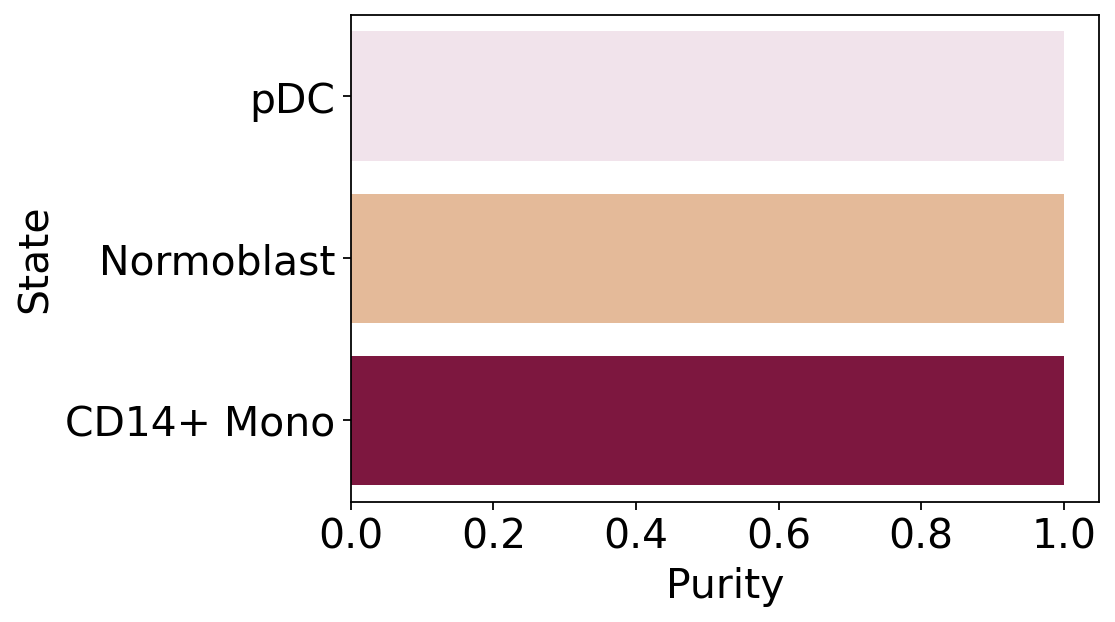

In [22]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="l2_cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"rna_velo_three_macrostate_purity.{FIGURE_FORMAT}"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))

    plot_state_purity(macrostate_purity, palette=palette, fpath=fpath, format=FIGURE_FORMAT)

In [23]:
terminal_states = ["CD14+ Mono", "Normoblast", "cDC2", "pDC"]
cluster_key = "l2_cell_type"

if (DATA_DIR / "hematopoiesis" / "results" / "tsi-vk.csv").is_file():
    tsi_df = pd.read_csv(DATA_DIR / "hematopoiesis" / "results" / "tsi-vk.csv")
    estimator._tsi = AnnData(tsi_df, uns={"terminal_states": terminal_states, "cluster_key": cluster_key})
    tsi_score = estimator.tsi(n_macrostates=17, terminal_states=terminal_states, cluster_key=cluster_key)
else:
    tsi_score = estimator.tsi(n_macrostates=17, terminal_states=terminal_states, cluster_key=cluster_key)
    estimator._tsi.to_df().to_csv(DATA_DIR / "hematopoiesis" / "results" / "tsi-vk.csv", index=False)

print(f"TSI score: {tsi_score:.2f}")

TSI score: 0.77


/vol/storage/miniconda3/envs/cr2-py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


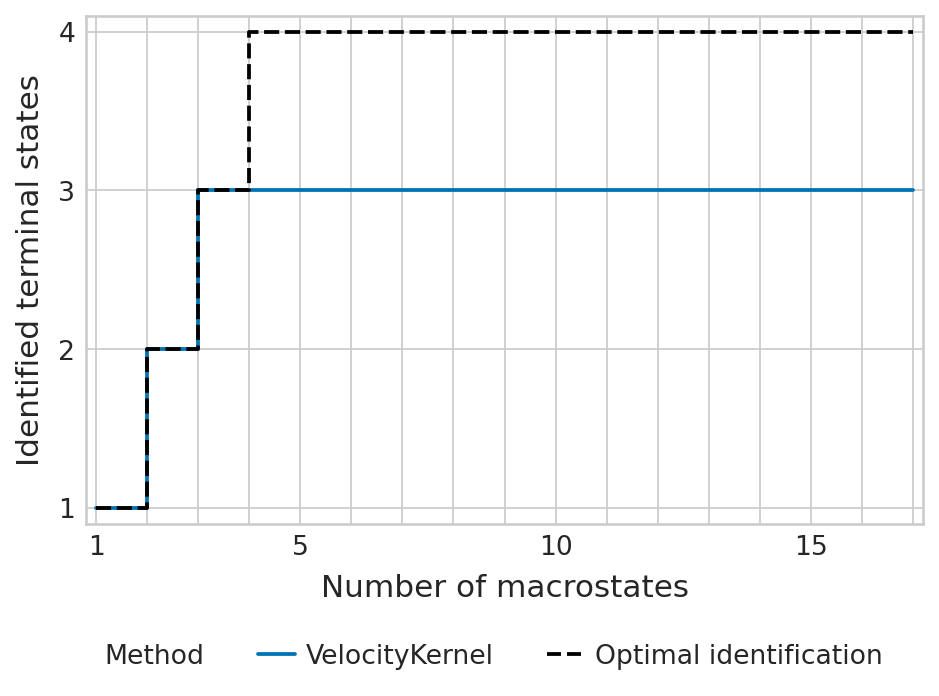

In [24]:
# For nice name in figure legend
estimator.kernel.__class__.__name__ = "VelocityKernel"
palette = {"VelocityKernel": "#0173b2", "Optimal identification": "#000000"}

if SAVE_FIGURES:
    fpath = FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"tsi-vk.{FIGURE_FORMAT}"
else:
    fpath = None

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    estimator.plot_tsi(palette=palette, save=fpath)
    plt.show()

DEBUG: Raising an exception if there are less than `6` cells.
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


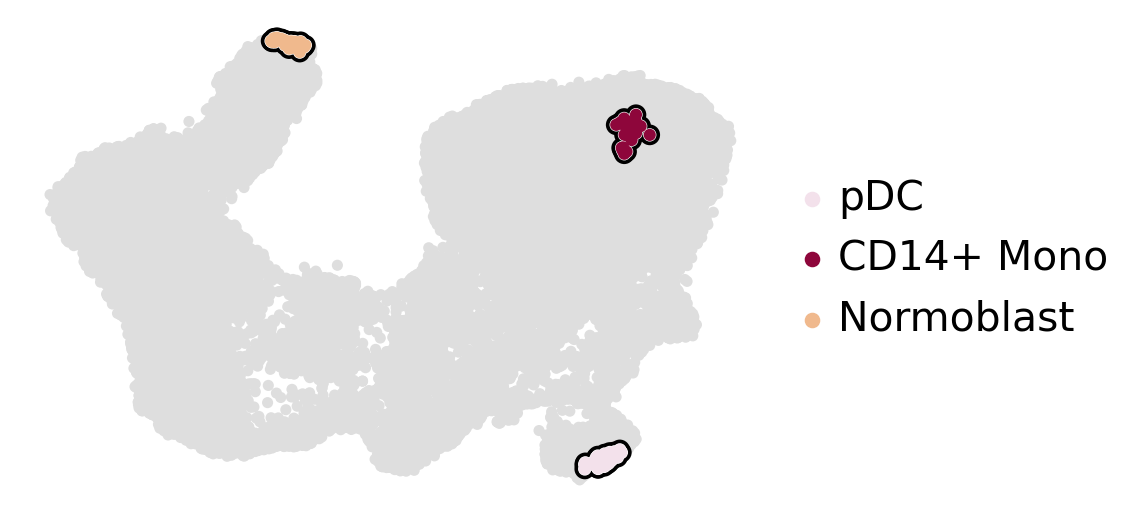

In [25]:
estimator.set_terminal_states(["pDC", "CD14+ Mono", "Normoblast"])
estimator.plot_macrostates(which="terminal", basis="umap", title="", legend_loc="right", size=100)
if SAVE_FIGURES:
    fpath = (
        FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"umap_colored_by_cr_rna_velo_terminal_states.{FIGURE_FORMAT}"
    )
    estimator.plot_macrostates(which="terminal", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Computing fate probabilities
DEBUG: Solving the linear system using `PETSc` solver `'gmres'` on `1` core(s) with no preconditioner and `tol=1e-07`


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


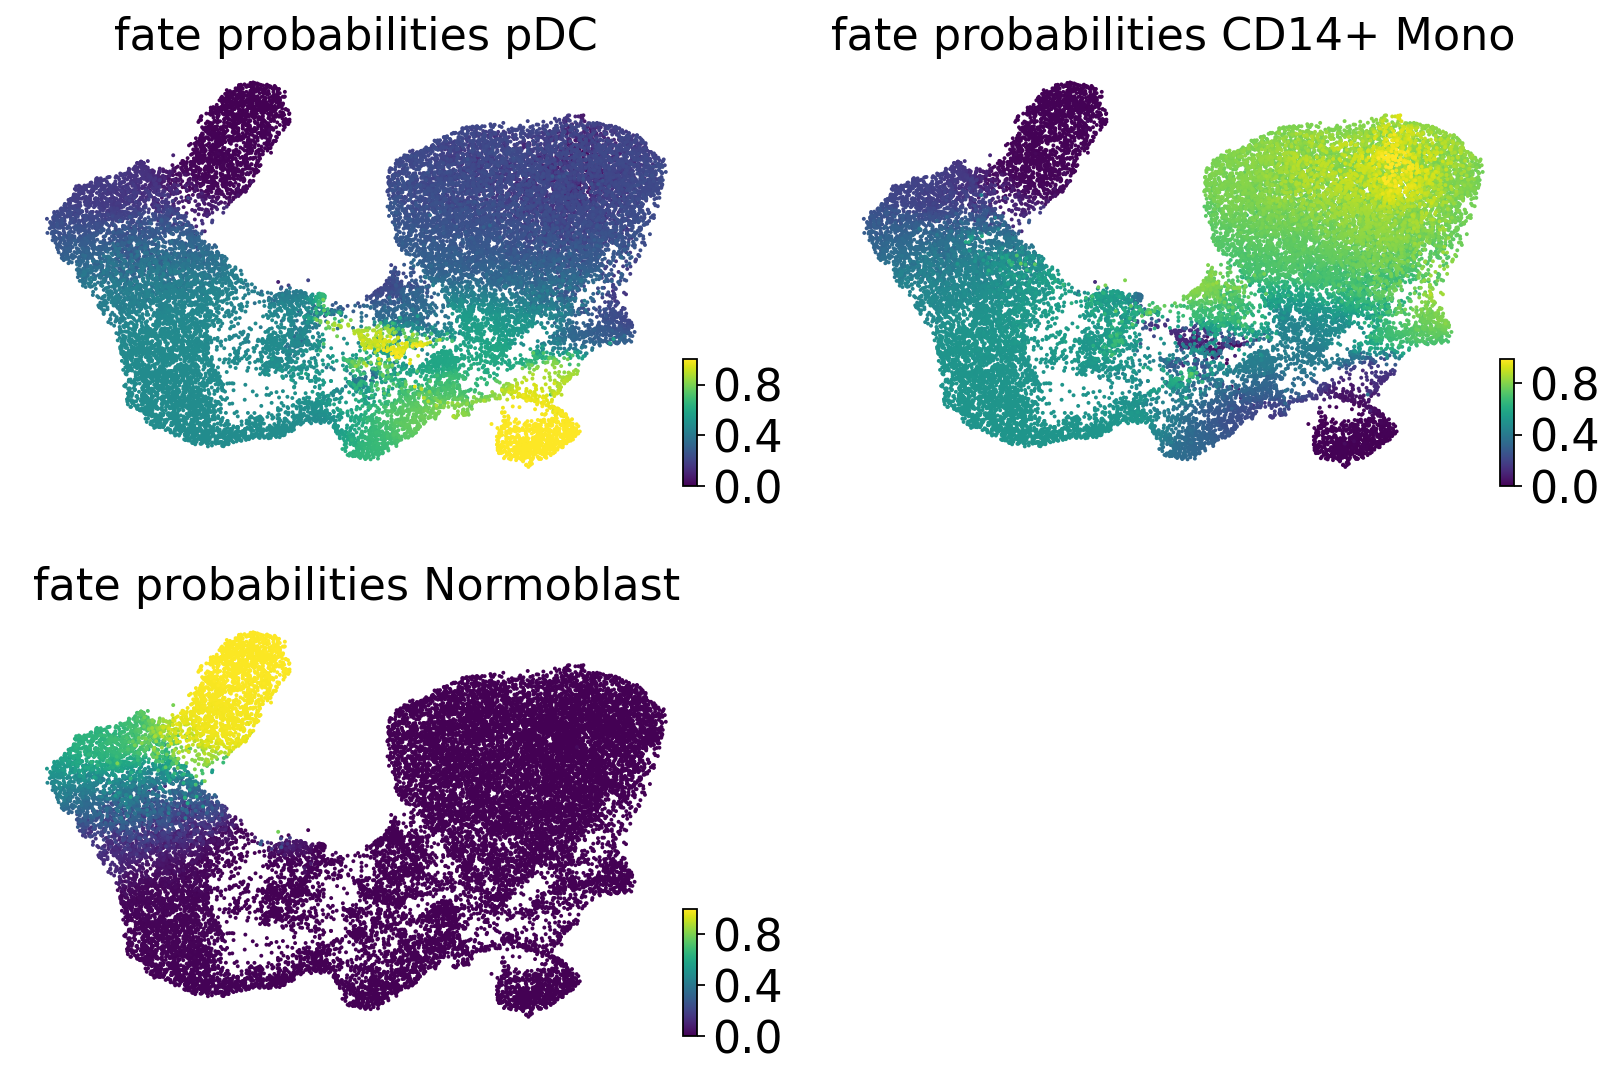

In [26]:
estimator.compute_fate_probabilities(tol=1e-7)
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, basis="X_umap", ncols=2)

if SAVE_FIGURES:
    adata.obs["fate_prob_pDC"] = adata.obsm["lineages_fwd"][:, "pDC"].X.squeeze()
    adata.obs["fate_prob_CD14+Mono"] = adata.obsm["lineages_fwd"][:, "CD14+ Mono"].X.squeeze()
    adata.obs["fate_prob_Normoblast"] = adata.obsm["lineages_fwd"][:, "Normoblast"].X.squeeze()

    for terminal_state in ["pDC", "CD14+Mono", "Normoblast"]:
        fig, ax = plt.subplots(figsize=(6, 4))

        if running_in_notebook():
            scv.pl.scatter(
                adata,
                basis="umap",
                color=f"fate_prob_{terminal_state}",
                cmap="viridis",
                title="",
                colorbar=False,
                ax=ax,
            )

            fig.savefig(
                FIG_DIR
                / "pseudotime_kernel"
                / "hematopoiesis"
                / f"rna_velo_fate_prob_{terminal_state}.{FIGURE_FORMAT}",
                format=FIGURE_FORMAT,
                transparent=True,
                bbox_inches="tight",
            )

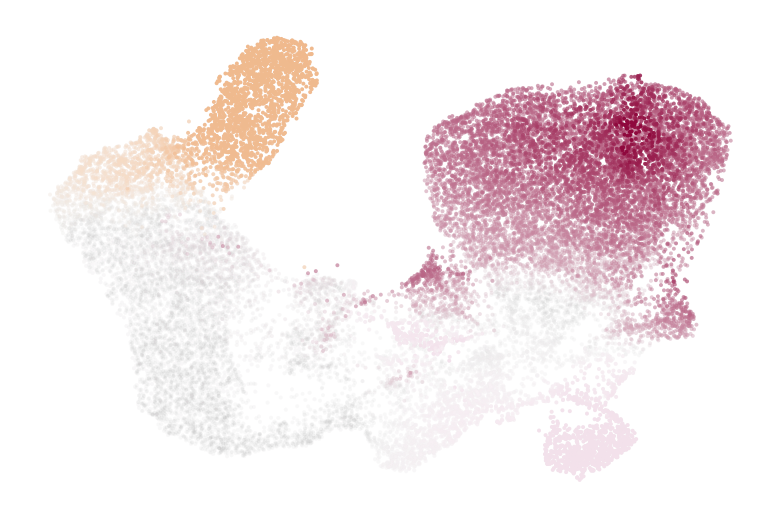

In [27]:
if running_in_notebook():
    if SAVE_FIGURES:
        fpath = f"{FIG_DIR}/pseudotime_kernel/hematopoiesis/umap_colored_by_rna_velo_fate.{FIGURE_FORMAT}"
    else:
        fpath = None
    fig, ax = plt.subplots(figsize=(6, 4))
    estimator.plot_fate_probabilities(
        same_plot=True,
        basis="umap",
        title="",
        legend_loc=False,
        save=fpath,
        ax=ax,
    )

Computing `21` macrostates
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:07:44)


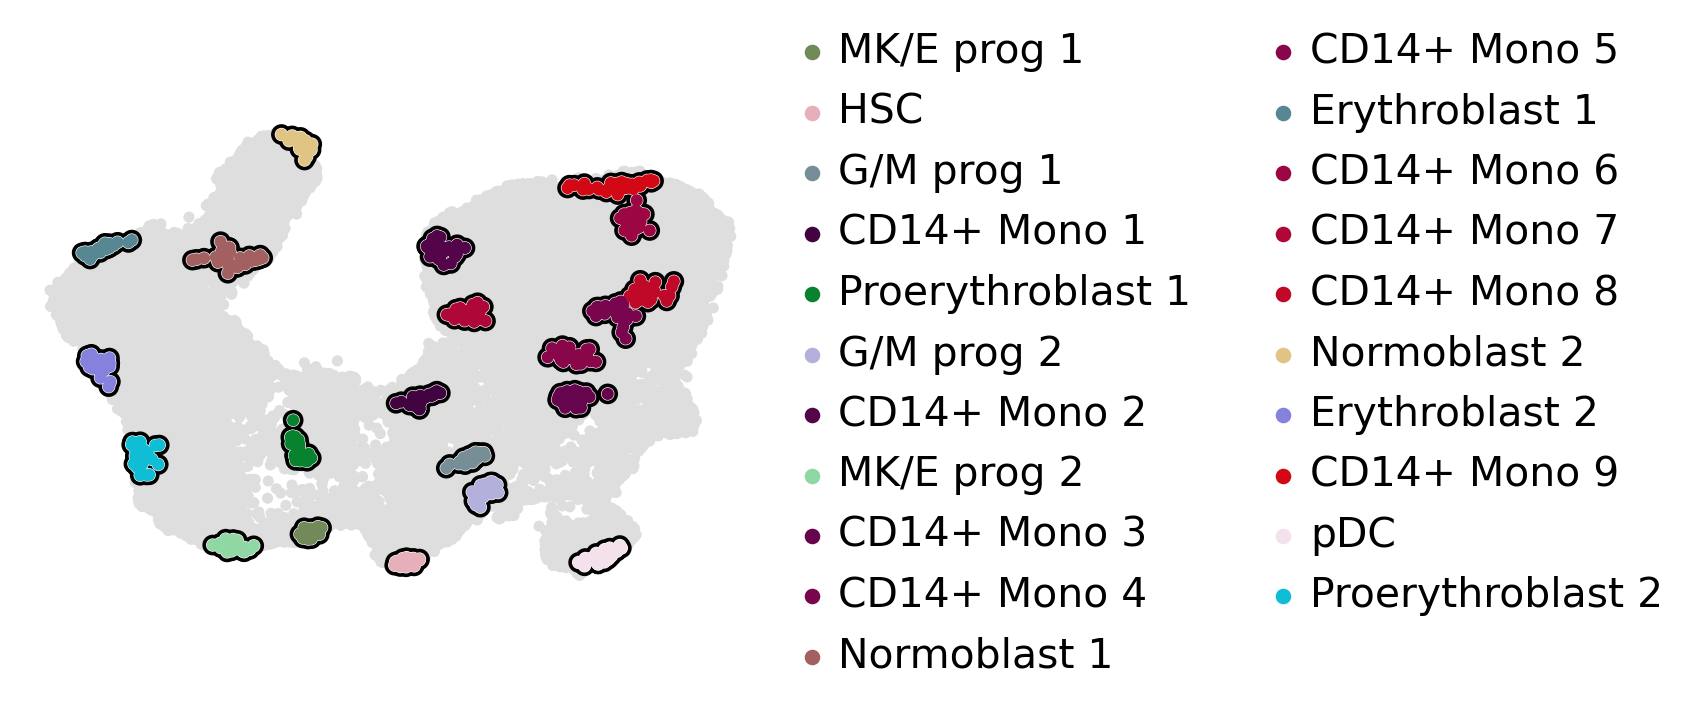

In [28]:
estimator.compute_macrostates(n_states=20, cluster_key="l2_cell_type")
estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc="right", size=100)
if SAVE_FIGURES:
    fpath = FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"umap_colored_by_rna_velo_20_macrostates.{FIGURE_FORMAT}"
    estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)

Mean purity: 0.8984126984126986


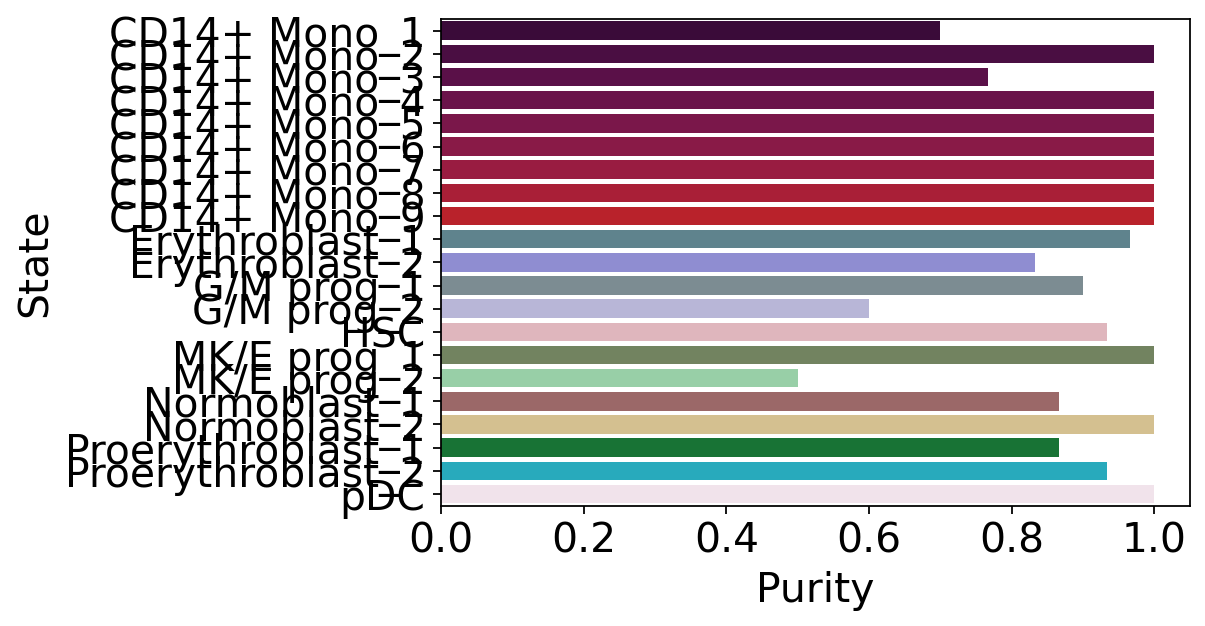

In [29]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="l2_cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "pseudotime_kernel" / "hematopoiesis" / f"rna_velo_20_macrostate_purity.{FIGURE_FORMAT}"
    else:
        fpath = None

    macrostates_ordered = estimator.macrostates.cat.categories.sort_values()
    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))

    plot_state_purity(macrostate_purity, order=macrostates_ordered, palette=palette, fpath=fpath, format=FIGURE_FORMAT)
    plt.show()